# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "dataset/train.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    

train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']
print("Data loaded :)")

Data loaded :)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(train_features)

# TODO: Number of testing examples.
n_test = len(test_features)

# TODO: What's the shape of an traffic sign image?
image_shape = train_features[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

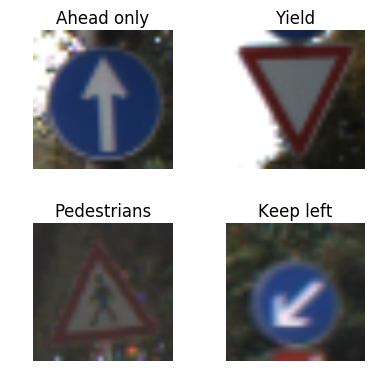

In [3]:
### Data exploration visualization goes here.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

#load label text function
def load_label_file(file):
    lines = open(file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

label_descriptions = load_label_file("signnames.csv")


#select samples from training data
n_samples = 4
isample = np.random.randint(0, n_train, n_samples)
sample_imgs = train_features[isample]
sample_labels = list(map(label_descriptions.get, train_labels[isample]))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(2*2, 2*2))
axes = axes.ravel()
fig.tight_layout()

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')



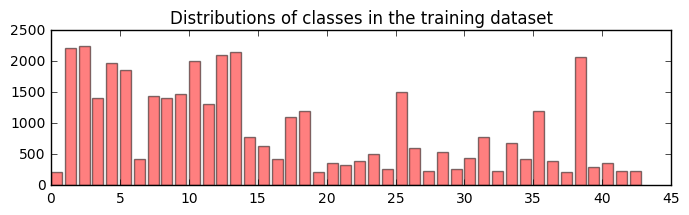

In [4]:
#lets look at the distributions of classes in the dataset
train_classes = np.bincount(train_labels)
plt.figure(figsize=(8, 2))
plt.bar(range(n_classes), train_classes, label="train", color="r", alpha=0.5)
plt.title("Distributions of classes in the training dataset")

    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

[STATE] Turning to YUV space:
YUV images


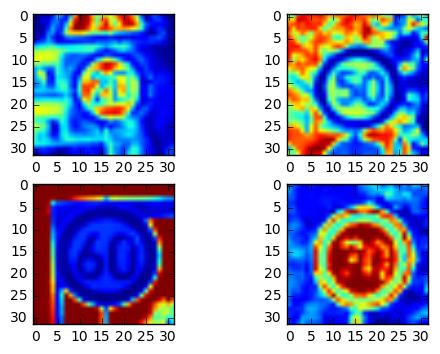

In [5]:
import cv2
print('[STATE] Turning to YUV space:')

def preprocess_yuvspace(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0] for img in images])

yuv = preprocess_yuvspace(train_features)

# Plot four sample images
print('YUV images')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(yuv[i*2500+1])

In [6]:


print('[STATE] Preprocessing data: ')

#import packages
import scipy.ndimage
from sklearn import cross_validation

yuv = train_features
inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

# Generate additional data for underrepresented classes
print('[STATE] Generating additional data:')
angles = [-30, 30, -60, 60, -90, 90, -120, 120]

for i in range(len(inputs_per_class)):
    input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)

    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_features[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    train_features = np.append(train_features, new_features, axis=0)
    train_labels = np.append(train_labels, new_labels, axis=0)



# Get randomized datasets for training and validation
print('[STATE] Randomizing:')
train_features, valid_features, train_labels, valid_labels = cross_validation.train_test_split(
   train_features,
   train_labels,
   test_size=0.2,
   random_state=832289
)

print('Data preprocessed')



[STATE] Preprocessing data: 
[STATE] Generating additional data:
[STATE] Randomizing:
Data preprocessed


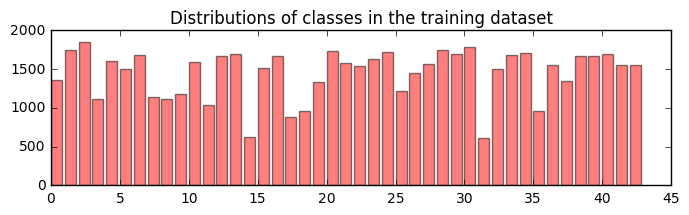

In [7]:
#lets look at the distributions of classes in the dataset
train_classes = np.bincount(train_labels)
plt.figure(figsize=(8, 2))
plt.bar(range(n_classes), train_classes, label="train", color="r", alpha=0.5)
plt.title("Distributions of classes in the training dataset")

    

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
* The first step is to convert the dataset into YUV space, this process weightes the values of B, G, and R are summed to 
produce Y, a measure of overall brightness or luminance.Then U and V are computed as scaled differences between Y′ and 
the B and R values. This tip was found in the Traffic Sign Recognition with Multi-Scale Convolutional Networks paper by 
Yann LeCun and seems to work better than using raw BGR dataset.

* After that when the class distribution in the dataset was analized it was detected a big difference between the quantity 
of examples in each class, then it was decided to generate more data based on those poor represented classes but changing 
some grades of each image.**

* Then the dataset was randomized.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer: **Beforehand there was provided a training and testing dataset, the only thing that was necessary was to split the testing data set in order to get a validation set. This was necessary due to we need that the model do not see the testing data until the very last moment we want to measure the performance, that's why the validation set is used to make a previous measure of the accuracy and the testing set for the final and las measure.The validation data was obtain after spliting 20% of the train data.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** Convolutional Neural Network are a powerfull neural network technique, these networks preserve the spatial structure of the problem and were developed for object recognition tasks such as handwritten digit recognition. They are popular because people are achieving state-of-the-art results on difficult computer vision and natural language processing tasks and why it was choosen to solve this classification task. LeNet architecture was implemented in this design with 5 layers in total: 

* 1 Convolutional layer with a 5 x 5 filter, 3 inputs and 6 outputs, it's used a ReLu activation function and a pooling layer at the end to consolidate the features learned.

* 1 Convolutional layer with a 5 x 5 filter, 6 inputs and 16 outputs, with a ReLu activation functino, pooling layer and a flatten layer to convert the 2D data into a vector that allaws the output to be processed by a standard fully connected layer.

* 1 Fully Connected that recives 400 parameters as inputs and output 120 parameters. This kind of networks are used at the end of the convolutional networks in order to express outputs as probabilities, just after feature extraction and consolidations has been performed by the convolution and pooling layers and ReLu activation function.

* 1 Fully Connected that recives 120 parameters as inputs and output 84 parameters and ReLu activation function.

* 1 Fully Connected that recives 84 parameters as inputs and output 43 final parameters.

In [8]:
from sklearn.cross_validation import train_test_split
n_train = len(train_features)
print("Number of training examples before =", n_train)

X_train, X_validation, y_train, y_validation = train_test_split(train_features, train_labels, test_size=0.2, random_state=7)
n_train = len(X_train)
val = len(X_validation)


print("Number of training examples after =", n_train)
print("Number of validation examples =", val)
print("Sum of both = ", val + n_train)

X_test = test_features
y_test = test_labels

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)



Number of training examples before = 62493
Number of training examples after = 49994
Number of validation examples = 12499
Sum of both =  62493


In [9]:
### Train your model here.
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128

train_features = yuv

In [10]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)



In [12]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.333

EPOCH 2 ...
Validation Accuracy = 0.623

EPOCH 3 ...
Validation Accuracy = 0.761

EPOCH 4 ...
Validation Accuracy = 0.813

EPOCH 5 ...
Validation Accuracy = 0.858

EPOCH 6 ...
Validation Accuracy = 0.864

EPOCH 7 ...
Validation Accuracy = 0.878

EPOCH 8 ...
Validation Accuracy = 0.894

EPOCH 9 ...
Validation Accuracy = 0.902

EPOCH 10 ...
Validation Accuracy = 0.909

EPOCH 11 ...
Validation Accuracy = 0.921

EPOCH 12 ...
Validation Accuracy = 0.914

EPOCH 13 ...
Validation Accuracy = 0.926

EPOCH 14 ...
Validation Accuracy = 0.924

EPOCH 15 ...
Validation Accuracy = 0.935

EPOCH 16 ...
Validation Accuracy = 0.939

EPOCH 17 ...
Validation Accuracy = 0.942

EPOCH 18 ...
Validation Accuracy = 0.943

EPOCH 19 ...
Validation Accuracy = 0.913

EPOCH 20 ...
Validation Accuracy = 0.937

EPOCH 21 ...
Validation Accuracy = 0.948

EPOCH 22 ...
Validation Accuracy = 0.933

EPOCH 23 ...
Validation Accuracy = 0.941

EPOCH 24 ...
Validation Accura

In [15]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Test Accuracy = 0.853


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** It was implemented using a:

* Adam Gradien Descent (Adaptive Moment Estimation) as an optimizer, is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients  also keeps an exponentially decaying average of past gradients. It's implemented because Adam use a larger effective step size than gradient descent and alsa uses less parameters tuning.

* Batch size of 128, the amount of samlpes the pc or gpu. A standard value for pc is 128.

* Epochs were 30 which are the iterations the networks is going to try. The more iterations the longer the training but also the model has more possibilities to reduce error, 30 is a good amount of iterations.

* mu = 0  and sigma = 0.1 which are parameters to initialize the weights.

* learning rate of 0.001 that sets the amount the weights can change when the neural network wants to optimize parameters. Is necessary to set it with a small value like It's done couse bigger values can tend  to not reach global optimum.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer: The LeNet architecture was the choosen, is a powerfull implementation of convolutional neural networks that is widely used in state of the art applications.The number of layers is already set and there were only few parameters that needed to be tuned. **

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

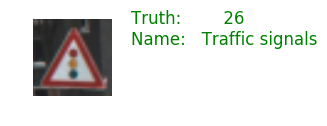

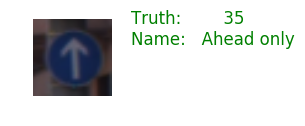

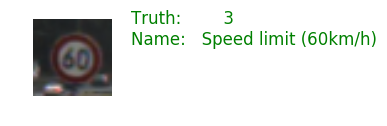

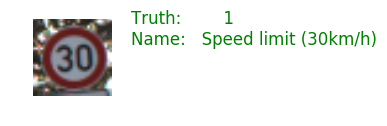

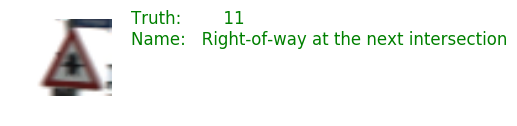

In [33]:
# pick some random pictures
sample_indexes = np.random.randint(len(y_test), size=5)
# extract the labels
y_truth = []
for img in sample_indexes:
    y_truth.append(y_test[img])
# pot random images with labels
fig = plt.figure(figsize=(10, 10))
intCount = 0
for image in sample_indexes:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    color='green'
    plt.text(40, 10, "Truth:        {0}\nName:   {1}".format(y_test[image], label_descriptions.get(y_test[image])), 
             fontsize=12, color=color)
    plt.imshow(X_test[image])
    intCount += 1

Test examples:  [10878  8299  4905  1558   498]
Top five:  TopKV2(values=array([[  1.00000000e+00,   1.01400381e-11,   1.87535339e-12,
          1.47910140e-13,   3.60266364e-15]], dtype=float32), indices=array([[27, 38,  1, 12, 19]], dtype=int32))

those are the output tags,  ['Pedestrians', 'Keep right', 'Speed limit (30km/h)', 'Priority road', 'Dangerous curve to the left']
['Pedestrians', 'Keep right', 'Speed limit (30km/h)', 'Priority road', 'Dangerous curve to the left']


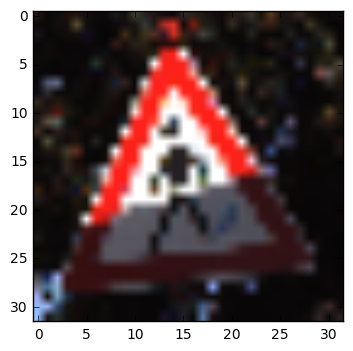

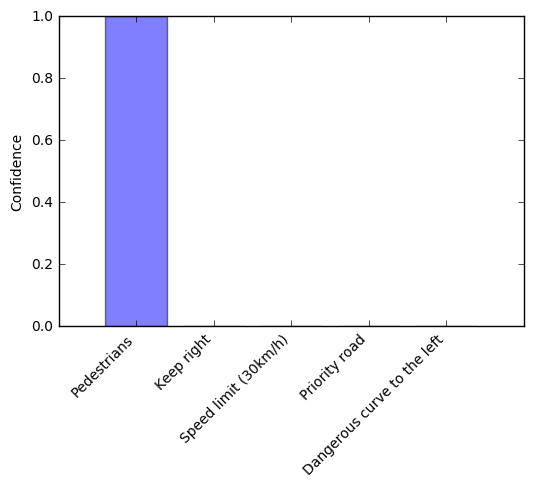

TopKV2(values=array([[  1.00000000e+00,   1.01400381e-11,   1.87535339e-12,
          1.47910140e-13,   3.60266364e-15]], dtype=float32), indices=array([[27, 38,  1, 12, 19]], dtype=int32))
Shape:  (32, 32, 3)
_________________________________________

Top five:  TopKV2(values=array([[  9.99997497e-01,   2.45113529e-06,   5.10560864e-12,
          1.18406261e-13,   1.27625573e-18]], dtype=float32), indices=array([[13, 19, 30, 28, 21]], dtype=int32))

those are the output tags,  ['Yield', 'Dangerous curve to the left', 'Beware of ice/snow', 'Children crossing', 'Double curve']
['Yield', 'Dangerous curve to the left', 'Beware of ice/snow', 'Children crossing', 'Double curve']


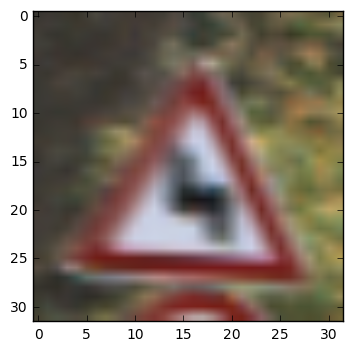

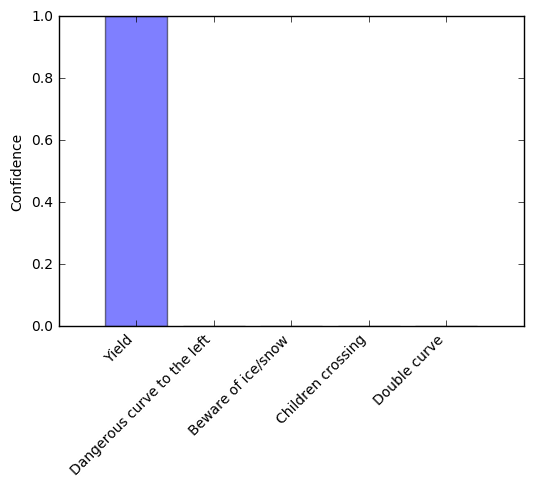

TopKV2(values=array([[  9.99997497e-01,   2.45113529e-06,   5.10560864e-12,
          1.18406261e-13,   1.27625573e-18]], dtype=float32), indices=array([[13, 19, 30, 28, 21]], dtype=int32))
Shape:  (32, 32, 3)
_________________________________________

Top five:  TopKV2(values=array([[  8.72783422e-01,   1.22974187e-01,   3.29453638e-03,
          8.35667481e-04,   6.79597215e-05]], dtype=float32), indices=array([[41, 13,  0, 17,  8]], dtype=int32))

those are the output tags,  ['End of no passing', 'Yield', 'Speed limit (20km/h)', 'No entry', 'Speed limit (120km/h)']
['End of no passing', 'Yield', 'Speed limit (20km/h)', 'No entry', 'Speed limit (120km/h)']


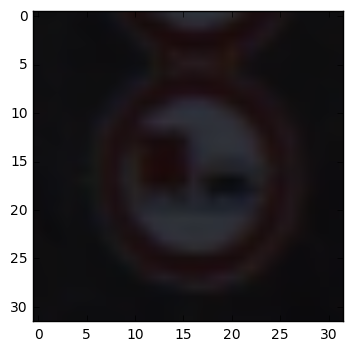

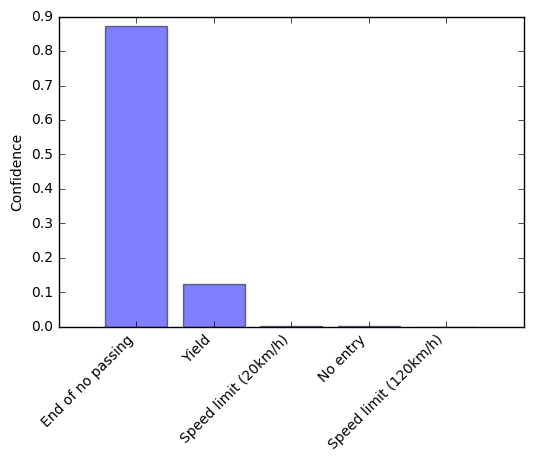

TopKV2(values=array([[  8.72783422e-01,   1.22974187e-01,   3.29453638e-03,
          8.35667481e-04,   6.79597215e-05]], dtype=float32), indices=array([[41, 13,  0, 17,  8]], dtype=int32))
Shape:  (32, 32, 3)
_________________________________________

Top five:  TopKV2(values=array([[  9.99996424e-01,   3.41052009e-06,   1.21058250e-07,
          2.48079779e-09,   2.19304130e-09]], dtype=float32), indices=array([[28, 14, 20, 12, 21]], dtype=int32))

those are the output tags,  ['Children crossing', 'Stop', 'Dangerous curve to the right', 'Priority road', 'Double curve']
['Children crossing', 'Stop', 'Dangerous curve to the right', 'Priority road', 'Double curve']


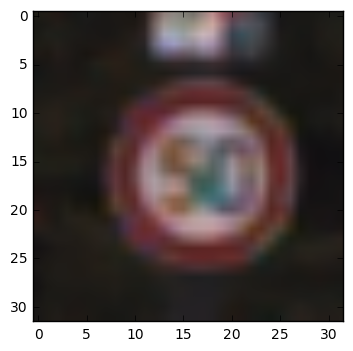

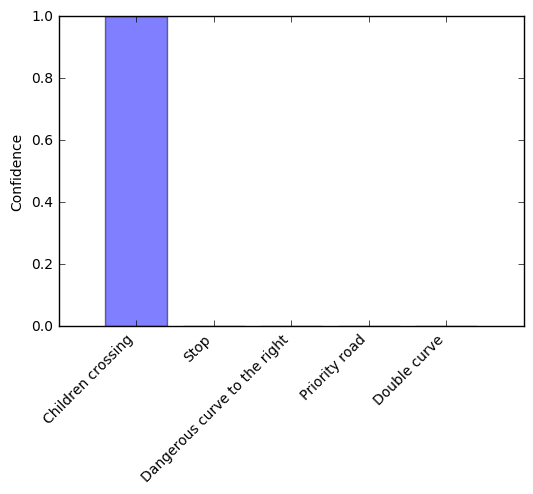

TopKV2(values=array([[  9.99996424e-01,   3.41052009e-06,   1.21058250e-07,
          2.48079779e-09,   2.19304130e-09]], dtype=float32), indices=array([[28, 14, 20, 12, 21]], dtype=int32))
Shape:  (32, 32, 3)
_________________________________________

Top five:  TopKV2(values=array([[ 0.66323608,  0.29740664,  0.02840321,  0.00445389,  0.00249845]], dtype=float32), indices=array([[39, 32, 41,  7,  3]], dtype=int32))

those are the output tags,  ['Keep left', 'End of all speed and passing limits', 'End of no passing', 'Speed limit (100km/h)', 'Speed limit (60km/h)']
['Keep left', 'End of all speed and passing limits', 'End of no passing', 'Speed limit (100km/h)', 'Speed limit (60km/h)']


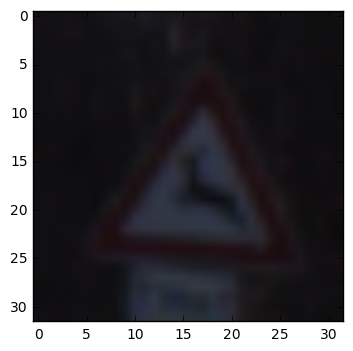

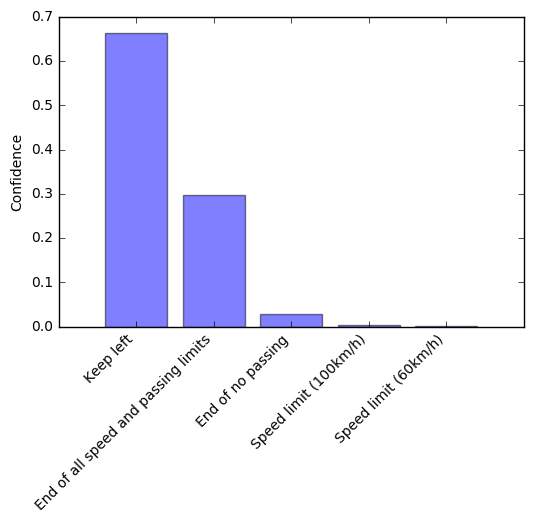

TopKV2(values=array([[ 0.66323608,  0.29740664,  0.02840321,  0.00445389,  0.00249845]], dtype=float32), indices=array([[39, 32, 41,  7,  3]], dtype=int32))
Shape:  (32, 32, 3)
_________________________________________



In [70]:
import matplotlib.pyplot as plt
#  implement the model to classify 
def certainty_of_predictions(img):    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        top_five = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: [img]})
        print("Top five: ", top_five)
        plt.figure(1)
        plt.imshow(img)
        plt.figure(2)
        objects = top_five[1][0]
        y_pos = np.arange(len(objects))
        performance = top_five[0][0]
        print()        
        tag = []
        # extracting the outputs
        for object in objects:
            tag.append(label_descriptions.get(object))
        # printing 
        print("those are the output tags, ", tag)
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, tag, ha='right', rotation=45)
        plt.ylabel('Confidence')
        print(tag)
        plt.show()
    return top_five
# select the number of samples and display them
tags = np.random.randint(len(y_test), size=5)
print("Test examples: ",tags)
for tag in tags:
    print(certainty_of_predictions(X_test[tag]))
    print("Shape: ",X_test[tag].shape)
    print("_________________________________________")
    print("")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer: **  From the prediction I did to the candidate image, the testing accuracy is 20%, however, the model prediction accuracy on the training set was 93,7% in the training set and 85,3% in the testing set. As a result, I believe my model did not perform well in the real world sit.. The following reason might affect the predictions:

* Quality of the image
* The Contrast of the image.
* The Angle of the traffic sign.
* Trainig the model with data that with different characteristics than the ones are going to face in real applications.
* Image might be jittered.
* The training data set does not include this traffic sign.
* Background Objects.
Some of the outputs were close when is anayzed the softmax output but there are tons of mistakes, it's so disapointing.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The accuracy is 0, the reasons were mentioned in the previous question.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer: ** In some cases the correct labels were inclueded in the final predictions, that is quite good at least even if most of the answers were wrong.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.